In [ ]:
"""
准备数据集
每个人单独标准化的数据，不需要再进行normalization
"""

import joblib
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import shap
shap.initjs()   # 初始化js库

import sys
sys.path.append('..')

from utils.utils_logger import logger_init
from utils.utils_model import form_params_grid
from utils.utils_iFEMG_feature import df_save_csv

In [16]:
# 读数据
data_df = pd.read_csv(r"E:\fuckinggggg\paper_iFEMG_4th\data\fea_normed250509.csv", index_col = None, header = 0)
# data_df = pd.read_csv(r"E:\Data\paper2\iFEMG\iFEMG_extension_abs_normed_all.csv", index_col = None, header = 0)

print(f"原始数据集shape：{data_df.shape}")
# print(data_df.head())

"""
数据清洗 remove the data bellow:
    1. NaN value
    2. label is MVC
"""
# replace 'MVC' with NaN
data_df = data_df.replace('MVC', np.nan)
# delete NaN value
data_df = data_df.dropna(how = 'any')

print(f"数据清洗数据集shape：{data_df.shape}")
# print(data_df.dtypes)

# 生成需要归一化的列名list
muscle_name_lst = ['RF', 'LF', 'SarT', 'BF', 'SemiT', 'VM']
feature_name_lst = ['initial_pressure_ave', 'FMG', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq']
col_lst = []
for muscle in muscle_name_lst:
    for fea in feature_name_lst:
        col_lst.append(muscle + fea)

print(f"特征数量: {len(col_lst)}")

原始数据集shape：(524, 58)
数据清洗数据集shape：(518, 58)
特征数量: 54


In [29]:
'''
随机划分训练集和测试集，进行cv参数搜索
选择数据集训练模型
'''
# 选择动作类型，前抬腿or后抬腿
motion_data_df = data_df[(data_df['motion_type'] == 'hou') & (data_df['side'] == 'affected')]

y_data = motion_data_df.loc[:, 'label'].values
x_data = motion_data_df.loc[:, col_lst].values

print(f"总数据量：{x_data.shape}")
print(y_data.shape)

# 划分训练集和测试集
train_data, test_data, train_label, test_label = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42, stratify = y_data)

"""
Grid searching best parameters of SVR model
"""
# 记录开始训练时间
start_time = time.perf_counter()

# 参数网格
'''
C: 较小的C允许更多训练误差, 可能导致欠拟合, 较大的C值减少训练误差, 可能导致过拟合
epsilon: 较大的ε值允许更多点位于不敏感带内, 模型更简单; 较小的ε值迫使模型更精确拟合更多点
gamma: 较小的gamma值意味着更大的相似半径, 较大的gamma值使每个样本的影响范围更小

# scoring参数：负均方误差('neg_mean_squared_error')，R²分数('r2')，平均绝对误差('neg_mean_absolute_error')
'''

# rbf核函数参数搜索
param_grid={
    "C": np.logspace(-3, 3, 7),
    "gamma": np.logspace(-3, 3, 7),
    "epsilon": [0.01, 0.1, 0.5, 1]
    }
svr = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='r2', n_jobs=-1)

'''
# 线性核参数搜索
# 参数搜索
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'epsilon': [0.01, 0.1, 0.5, 1]
    }
svr = GridSearchCV(SVR(kernel='linear'), param_grid, cv=5, scoring='r2', n_jobs=-1)
'''

svr.fit(train_data, train_label)
print(f"Best params: {svr.best_params_}")

end_time = time.perf_counter()
print(f"training time(min): {(end_time - start_time)/60}")

score_test = svr.score(test_data, test_label)
score_train = svr.score(train_data, train_label)
print(f"train score: {str(score_train)}")
print(f"test score: {str(score_test)}")
test_pre = svr.predict(test_data)
train_pre = svr.predict(train_data)
print(f"train mean squared error: {mean_squared_error(train_label, train_pre)}")
print(f"test mean squared error: {mean_squared_error(test_label, test_pre)}")


总数据量：(138, 54)
(138,)
Best params: {'C': 10.0, 'epsilon': 0.01, 'gamma': 0.01}
training time(min): 0.015362209999996898
train score: 0.9992244823978991
test score: 0.8761850220398978
train mean squared error: 0.0011732748119057316
test mean squared error: 0.1886836032115205


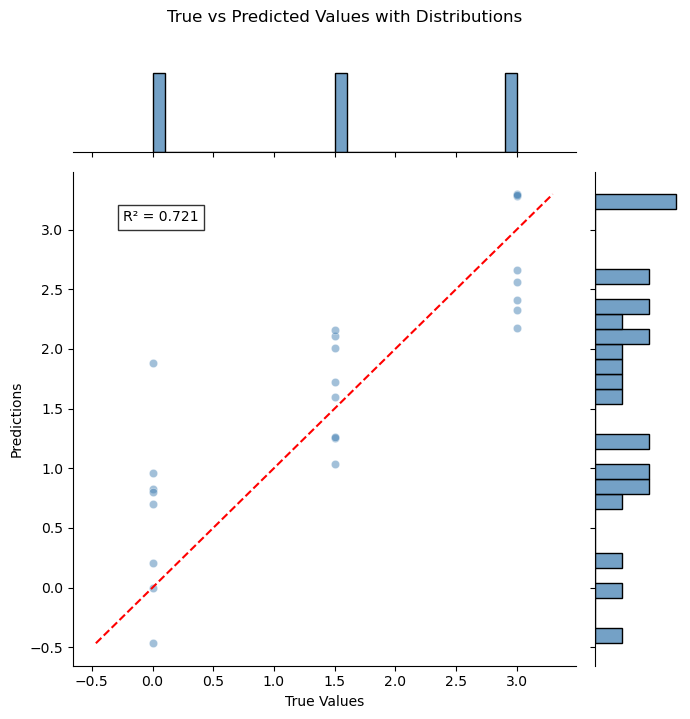

In [ ]:
# 可视化预测值与真实值对比
# 创建DataFrame
err_df = pd.DataFrame({'True Values': test_label, 'Predictions': test_pre})

# 使用jointplot同时展示散点和分布
g = sns.jointplot(data=err_df,
                  x='True Values',
                  y='Predictions',
                  kind='scatter',  # 主图类型
                  joint_kws={'alpha': 0.5, 'color': 'steelblue'},  # 散点图参数
                  marginal_kws={'bins': 30, 'color': 'steelblue'},  # 边缘分布参数
                  height=7)

# 添加对角线
g.ax_joint.plot([err_df.min().min(), err_df.max().max()], 
                [err_df.min().min(), err_df.max().max()], 
                'r--', linewidth=1.5)

# 计算并显示R²
from sklearn.metrics import r2_score
r2 = r2_score(test_label, test_pre)
g.ax_joint.text(0.1, 0.9, f'R² = {r2:.3f}', 
                transform=g.ax_joint.transAxes,
                bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('True vs Predicted Values with Distributions', y=1.02)
plt.tight_layout()
plt.show()

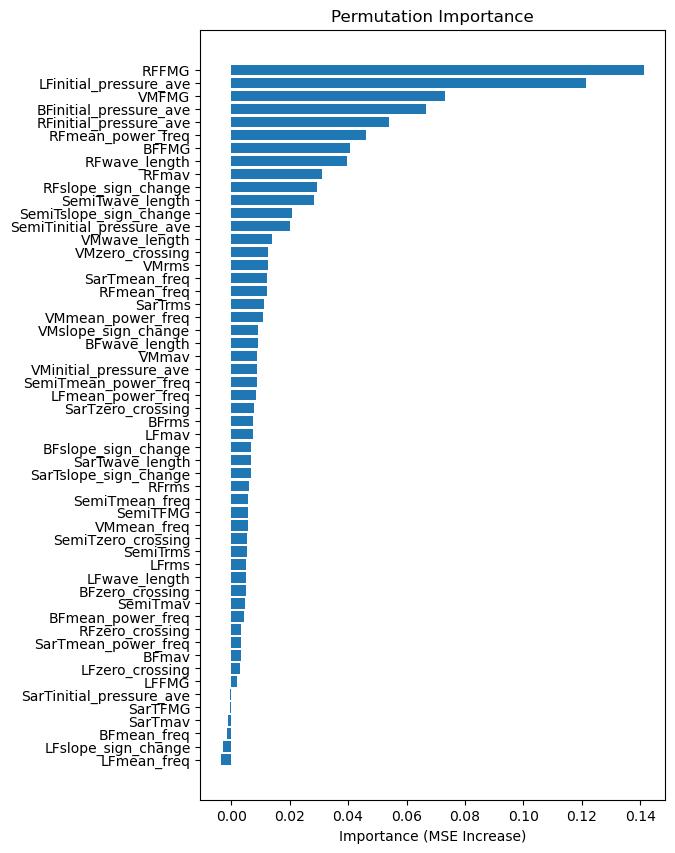

In [30]:
# permutation importance 方法，识别特征对模型的重要性
# 原理：计算模型基准性能后，随机打乱某一特征值，观察对模型性能的影响
# 结果解读：正重要性值，表示打乱该特征后模型性能下降（值越大，特征越重要）；负值或接近零：说明该特征对模型预测无贡献（甚至可能是噪声）。

result = permutation_importance(svr, test_data, test_label, n_repeats=10, scoring='r2')
importance_df = pd.DataFrame({
    'feature': col_lst,
    'importance': result.importances_mean
}).sort_values('importance', ascending=True)

# 绘制条形图
plt.figure(figsize=(6, 10)) # 设定图片的宽和高
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance (MSE Increase)')
plt.title('Permutation Importance')
plt.show()

Using 110 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/28 [00:00<?, ?it/s]

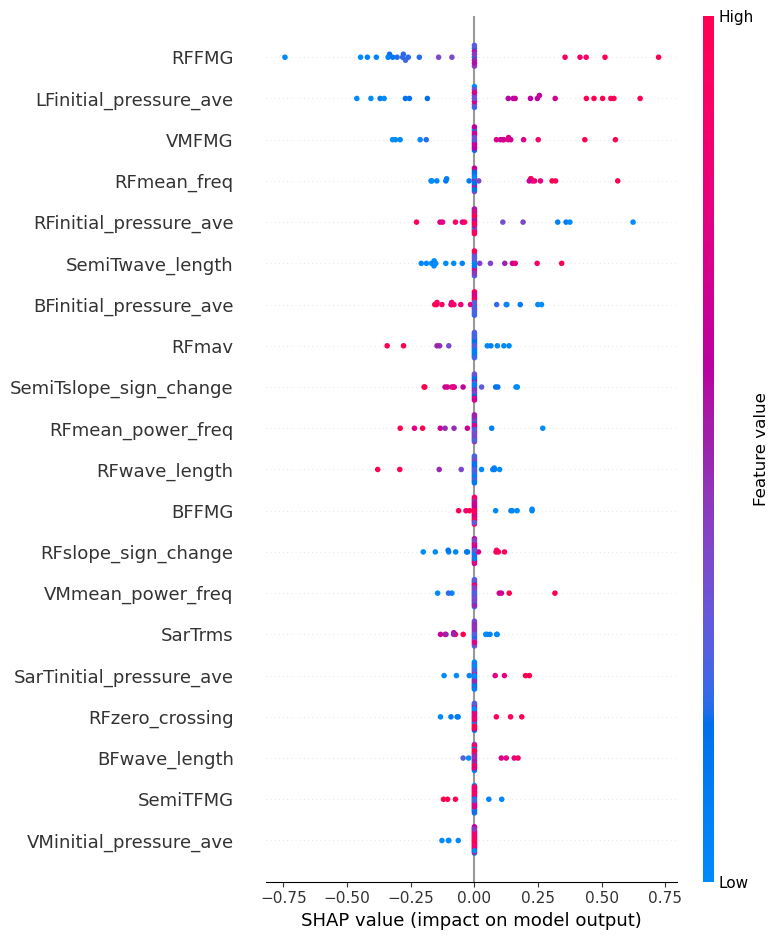

In [31]:
# shap值量化每个特征对单个样本预测的贡献，基于合作博弈论，公平分配特征对预测的贡献。
# 特性：
    # 局部解释：针对单个样本的预测。
    # 全局一致性：所有特征的SHAP值之和等于预测值与基线（如训练集均值）的差。
    # 方向性：正值表示提升预测，负值表示降低预测。

# 初始化解释器
# explainer = shap.LinearExplainer(model, X_scaled) # （针对线性模型使用LinearExplainer）
explainer = shap.KernelExplainer(svr.predict, train_data)  # 使用通用解释器（适用于任何模型，包括非线性SVR）注意计算较慢

# 计算测试集的SHAP值
shap_values = explainer.shap_values(test_data)

# 可视化全局特征重要性
# 从上到下按特征重要性排序
# 红色点在右边、蓝色点在左边，说明特征值对预测值有正效应
# 红色点在左边、蓝色点在右边，说明特征值对预测值有负效应
shap.summary_plot(shap_values, test_data, feature_names=col_lst)

# 可视化单个样本解释（如测试集第0个样本）
# 反应各个特征如何将结果推向当前的预测值
# 可以用于解释单个预测结果
shap.force_plot(explainer.expected_value, shap_values[0], test_data[0])



In [12]:
shap.force_plot(explainer.expected_value, shap_values[0], test_data[0])

In [13]:
len(col_lst)

54

In [ ]:
# 保存测试集输出结果
test_err_df = pd.DataFrame({'y_true': test_label,
                            'y_predict': test_pre})

df_save_csv(test_err_df, r"E:\Data\paper2\肌力预测模型结果\test_err_extension_8020.csv")